In [1]:
# Flow_from_directory
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.regularizers import L2
import pandas as pd


2022-10-05 15:58:08.319777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMAGE_SIZE = 224

# Test data
test_generator = ImageDataGenerator(rescale=1./255)
test = test_generator.flow_from_directory('data/cropped/mass/test/', target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=16, class_mode='binary')

Found 378 images belonging to 2 classes.


In [3]:
# load model
model = load_model('model-best-eller.h5')

2022-10-05 15:58:14.034446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


24/24 [==============================] - 19s 753ms/step


Text(0, 0.5, 'True positive rate')

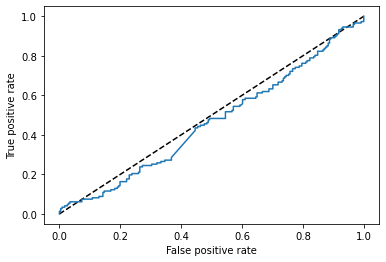

In [7]:
# Create roc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Get the predictions from the model using the generator
predictions = model.predict(test)

# Get the true values from the generator
true_values = test.classes

# Get the predicted probabilities for each class
pred_probabilities = predictions

# Get the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(true_values, pred_probabilities)

# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ResNet152')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

### Recall, percission and accuracy

In [8]:
# helper funcitons
def get_recall_i(conf_mat, i):
    """
    Computes.
    """
    return conf_mat[i, i] / np.sum(conf_mat[:, i])


def get_all_recalls(conf_mat):
    """
    Computes All recalls
    """

    return [get_recall_i(conf_mat, i) for i in range(conf_mat.shape[0])]


def get_percision_i(conf_mat, i):
    """
    Computes.
    """
    return conf_mat[i, i] / np.sum(conf_mat[i, :])


def get_all_percisions(conf_mat):
    """
    Computes all percisions.
    """

    return [get_percision_i(conf_mat, i) for i in range(conf_mat.shape[0])]


def get_overall_accuracy(conf_mat):
    """
    Computes the overall accuracy of the given confusion matrix.
    """
    return np.trace(conf_mat) / np.sum(conf_mat)

def get_confusion_matrix(result):
    result["Rounded"] = result["Prediction"].round()
    
    # creates confusion matrix
    true_positive_fake = result[(result['Filename'].str.contains(
        'benign')) & (result['Rounded'] == 0)].count()[0]
    false_positive_fake = result[(result['Filename'].str.contains(
        'malignant')) & (result['Rounded'] == 0)].count()[0]

    true_positive_real = result[(result['Filename'].str.contains(
        'malignant')) & (result['Rounded'] == 1)].count()[0]
    false_positive_real = result[(result['Filename'].str.contains(
        'benign')) & (result['Rounded'] == 1)].count()[0]

    conf_matrix = np.matrix([
        [true_positive_fake, false_positive_fake],
        [false_positive_real, true_positive_real]
    ])
    
    return conf_matrix

In [9]:
# predictions and evaluation
pred_res = model.predict(
            test,
            verbose=1)

24/24 [==============================] - 17s 708ms/step


In [14]:
test_results = pd.DataFrame({
                "Filename": test.filenames,
                "Prediction": pred_res.flatten()
            })
test_results

,Filename,Prediction
0,benign/1.3.6.1.4.1.9590.100.1.2.10106329241321...,0.517846
1,benign/1.3.6.1.4.1.9590.100.1.2.10531018721289...,0.461360
2,benign/1.3.6.1.4.1.9590.100.1.2.10658885911501...,0.513695
3,benign/1.3.6.1.4.1.9590.100.1.2.11095382651013...,0.598174
4,benign/1.3.6.1.4.1.9590.100.1.2.11211547581304...,0.490804
...,...,...
373,malignant/1.3.6.1.4.1.9590.100.1.2.90316691111...,0.505157
374,malignant/1.3.6.1.4.1.9590.100.1.2.92625977011...,0.509483
375,malignant/1.3.6.1.4.1.9590.100.1.2.94296125711...,0.449712
376,malignant/1.3.6.1.4.1.9590.100.1.2.94480099112...,0.530642


In [11]:
conf_matrix = get_confusion_matrix(test_results)
print("conf_matrix: \n", conf_matrix)
print("Recalls:", np.round(get_all_recalls(conf_matrix), 3))
print("Precisions:", np.round(get_all_percisions(conf_matrix), 3))
print("Accurcy:", np.round(get_overall_accuracy(conf_matrix), 3))

conf_matrix: 
 [[ 98  59]
 [133  88]]
Recalls: [0.424 0.599]
Precisions: [0.624 0.398]
Accurcy: 0.492
